# Does discounting moderates rate of BMI gain with age?
This notebook tests the hypothesis that log discount rates moderate the rate at which we gain BMI with age. The basic approach is one of Bayesian moderation analysis. Before we get to the Bayesian part, let's just consider the model.

## The moderation model approach

First, we will consider a 'full' moderation analysis:

$$
BMI = \beta_0 + (\beta_1 \cdot age) +  (\beta_2 \cdot age \cdot logk) + (\beta_3 \cdot logk)
$$

Where:
- $\beta_0$ is the intercept
- $\beta_1$ is the rate at which BMI increases per year of age. If $\beta_1>0$ then we have a main effect of age. 
- $\beta_2$ is the coefficient for the moderation term $age \cdot logk$.
- $\beta_3$ is the way in which BMI increases as `logk` increases. If $\beta_3>0$ then we have a main effect of discount rate. 

We already know from previous analyses that there is a main effect of age, in that BMI increases with age.

We also know that there is no main effect of discount rate.

Because of this, we are not going to focus on the 'full' moderation model above. Instead we focus on a reduced model which removes the lone effect of discount rate. 

$$
BMI = \beta_0 + (\beta_1 \cdot age)  + (\beta_2 \cdot age \cdot logk) 
$$

Before we do that, we are going to further motivate this model from a different angle.

Let's consider our precise hypothesis: that discount rates determine the rate at which BMI increases with age. We can formulate this as follows:

$$
BMI = \beta_0 + (slope \cdot age)
$$

![moderation model](img/moderation.png)

where

$$
slope = \beta_1 + \beta_2 \cdot logk
$$

![moderation model](img/moderation_slope.png)

If we combine the last two equations then we get

$$
BMI = \beta_0 + (slope \cdot age)\\
 = \beta_0 + ((\beta_1 + \beta_2 \cdot logk) \cdot age)\\
 = \beta_0 + (age \cdot \beta_1) + ( \beta_2 \cdot age \cdot logk)
$$

which results in the reduced model. So now we have considered 2 motivations for this reduced model.

## The Bayesian model
Here is the Bayesian specification of the model

$$
\beta_0 \sim \mathrm{Normal}(20,10)\\
\beta_1 \sim \mathrm{Normal}(5,10)\\
\beta_2 \sim \mathrm{Normal}(0,10)\\
\sigma \sim \mathrm{HalfCauchy}(10)\\
BMI \sim \mathrm{Normal}( \beta_0 + ( \beta_2 \cdot age \cdot logk) + (age \cdot \beta_1) , \sigma)
$$


In [1]:
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [2]:
# from matplotlib.font_manager import _rebuild; _rebuild()

In [3]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Load and process data

In [4]:
data = pd.read_csv('data/all_cleaned_scored.csv')

# convert age from units of years into decades
data['age'] = data['age']/10

# create predictors for the moderation analysis
data['logkmoney*age'] = data['logk_money'] * data['age']
data['logkweight*age'] = data['logk_weight'] * data['age']

Examine the relationshipn between age and BMI, we know from a previous analysis that there is a meaningful positive relationshiop here.

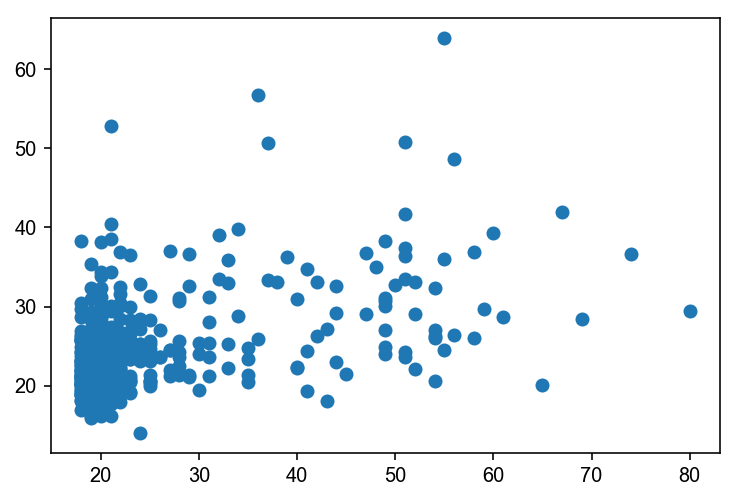

In [5]:
plt.scatter(data['age']*10, data['bmi']);

Examine the relationship between age and the moderator variables. We have one for discounting of money and one for discounting of weight loss. We are going to deal with these seperately.

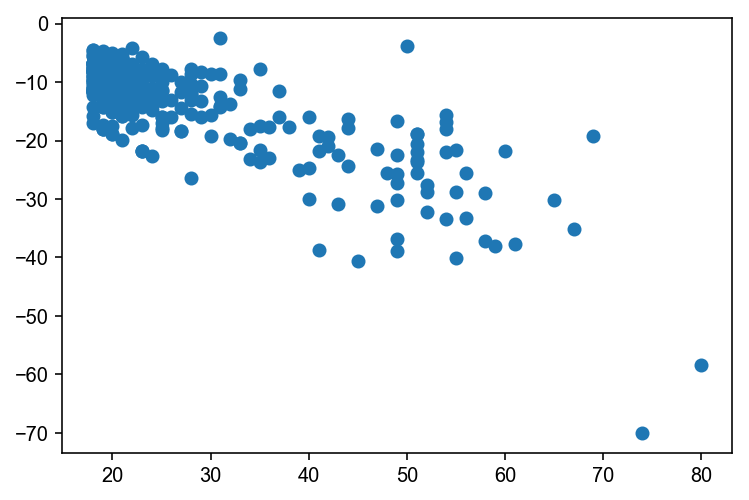

In [6]:
plt.scatter(data['age']*10, data['logkmoney*age'])

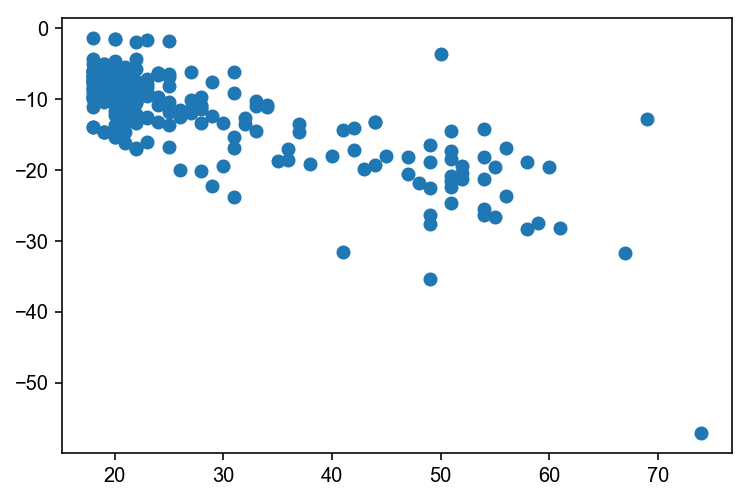

In [7]:
plt.scatter(data['age']*10, data['logkweight*age'])

Define function to plot moderation.

In [8]:
def plot_moderation(ax, x, intercept, slope, ax_kwargs):
    
    xi = np.linspace(min(x), max(x), 10)
    
    # plot samples
    for n in range(200):
        ax.plot(xi, (intercept[n] + slope[n] * xi) , color='k', alpha=0.05)

    # plot posterior mean
    ax.plot(xi, (np.mean(intercept) + np.mean(slope) * xi) , color='k', linewidth=3)
    ax.set(**ax_kwargs)
    
    # add points
    xi = np.percentile(x, [0, 100])
    ax.scatter(xi[0], (np.mean(intercept) + np.mean(slope) * xi[0]) , color='b', s=10**2, label='min')
    ax.scatter(xi[1], (np.mean(intercept) + np.mean(slope) * xi[1]) , color='r', s=10**2, label='max')
    
    ax.legend(loc='upper left')
    return ax

## Bayesian model
Set up the Bayesian model in PyMC3.

In [9]:
sample_options = {'tune': 3_000, 'draws': 10_000,
                  'chains': 4, 'cores': 4,
                  'nuts_kwargs': {'target_accept': 0.97},
                  'random_seed': 12345}

In [10]:
def make_model(x, y, m):
    '''Returns a PyMC3 model.
    x = age
    y = bmi
    m = moderator
    '''
        
    with pm.Model() as model:
        
        β0 = pm.Normal('β0', mu=20, sd=10)  # BMI intercept at age = zero
        β1 = pm.Normal('β1', mu=5, sd=10)  # age slope
        β2 = pm.Normal('β2', mu=0, sd=10)  # moderator slope
        
        σ = pm.HalfCauchy('σ', 10)
        
        y = pm.Normal('y', mu=β0+(β1*x)+(β2*m), sd=σ, observed=y)
    
    return model

# Inference for discounting of money

In [11]:
model = make_model(x=data['age'], y=data['bmi'], m=data['logkmoney*age'])

In [12]:
# model

In [13]:
# pm.model_to_graphviz(model)

In [14]:
with model:
    posterior_money = pm.sample(**sample_options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β2, β1, β0]
Sampling 4 chains: 100%|██████████| 52000/52000 [00:35<00:00, 1462.89draws/s]


Check the inference with forest plot and $\hat{R}$ statistic.

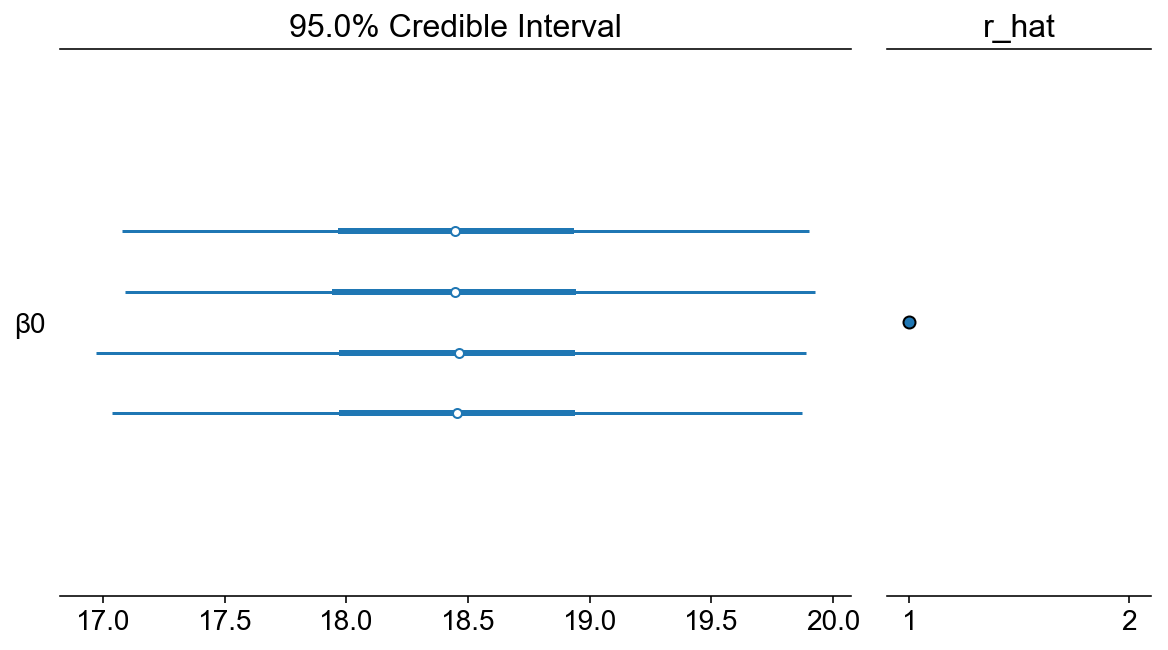

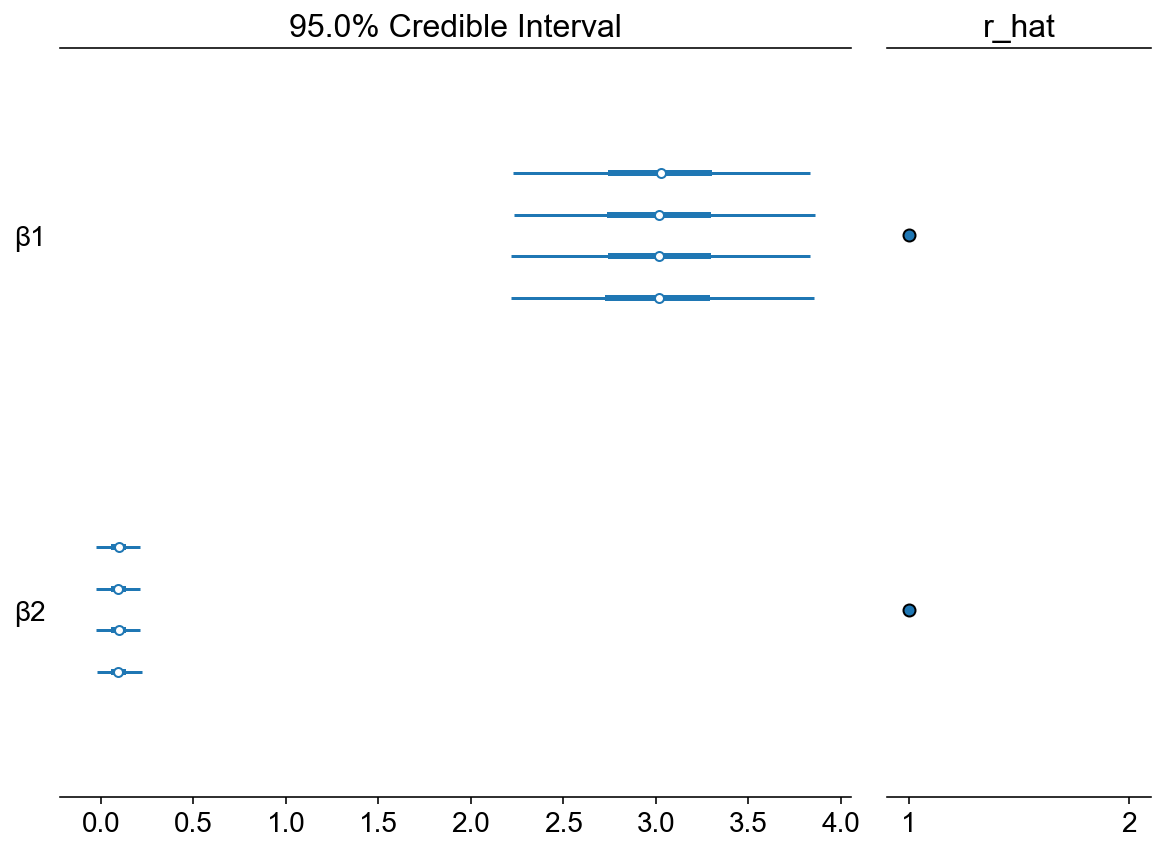

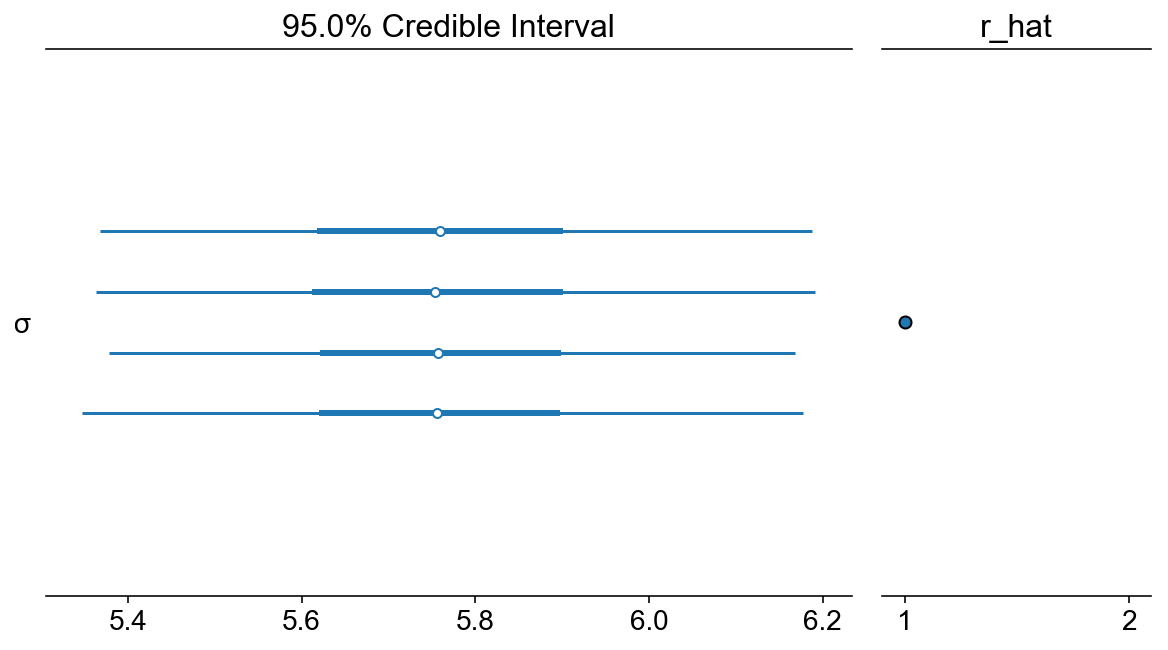

In [15]:
pm.forestplot(posterior_money, var_names=['β0'], r_hat=True, credible_interval=0.95);
pm.forestplot(posterior_money, var_names=['β1', 'β2'], r_hat=True, credible_interval=0.95);
pm.forestplot(posterior_money, var_names=['σ'], r_hat=True, credible_interval=0.95);

Posterior for $\sigma$

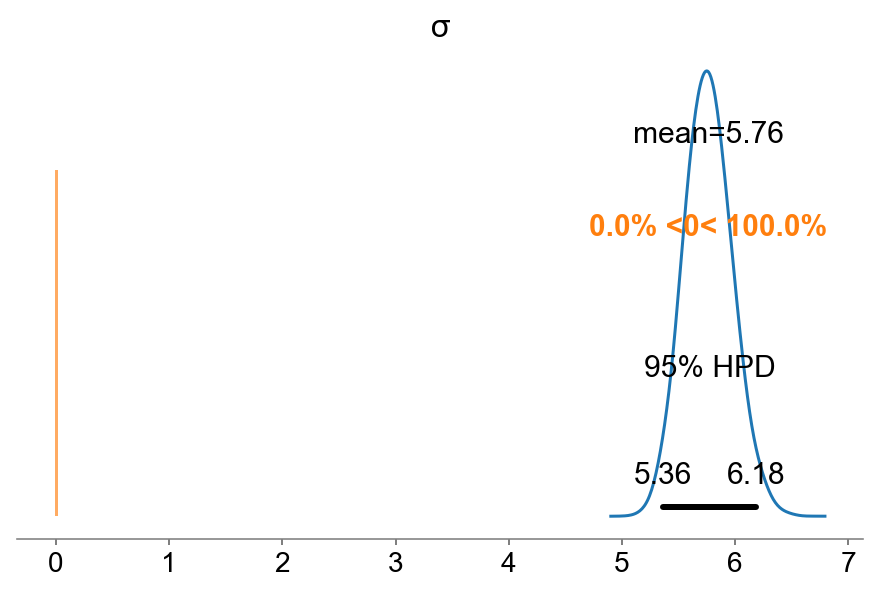

In [16]:
pm.plot_posterior(posterior_money, var_names=['σ'], ref_val=0, color='#87ceeb', round_to=2, credible_interval=0.95);

Posterior for the intercept, $\beta_0$

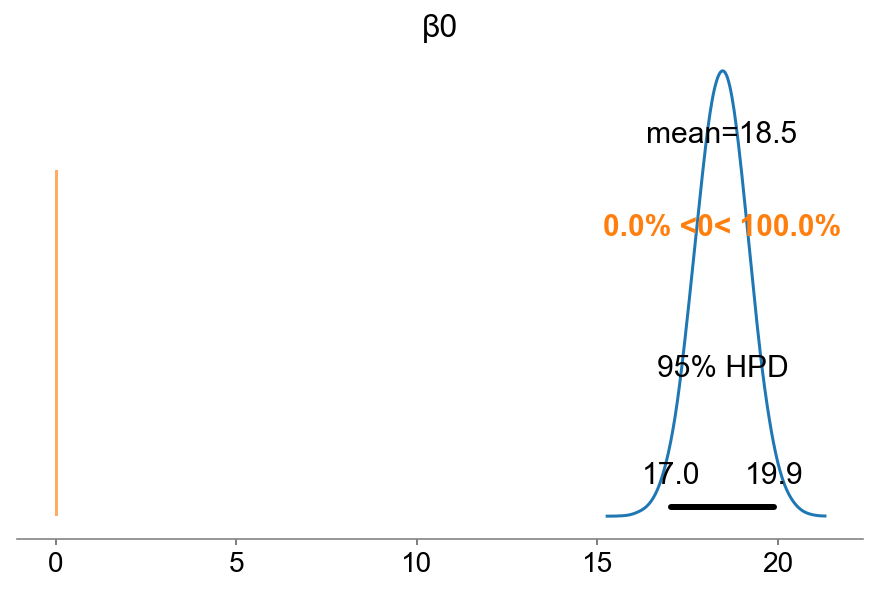

In [17]:
pm.plot_posterior(posterior_money, var_names=['β0'], ref_val=0, color='#87ceeb', credible_interval=0.95);

Posterior age coefficient, $\beta_1$, which is the BMI gain per year.

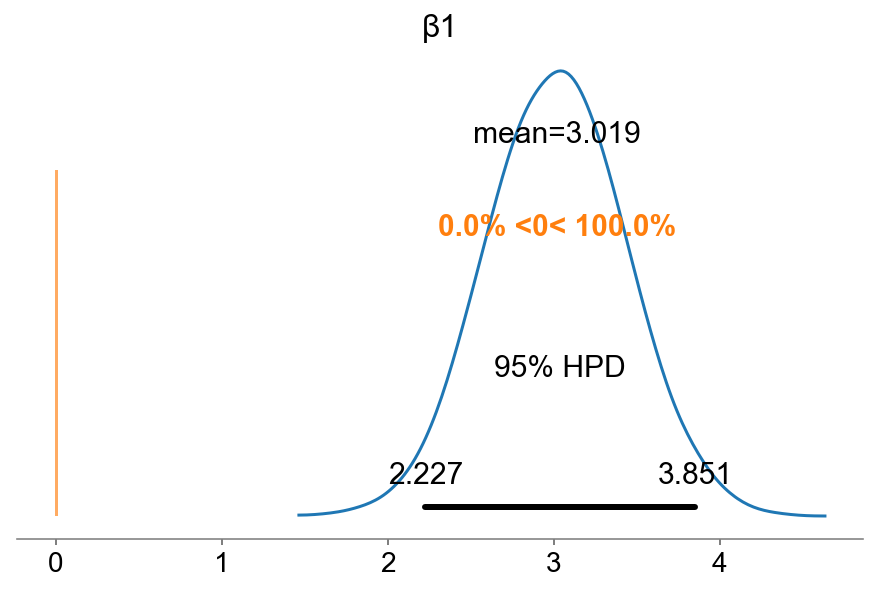

In [18]:
pm.plot_posterior(posterior_money, var_names=['β1'], ref_val=0, color='#87ceeb', round_to=3, credible_interval=0.95);

In [19]:
# posterior mean and std of β1
np.mean(posterior_money['β1']), np.std(posterior_money['β1'])

(3.01859918193507, 0.41494137341830856)

Posterior distribution for the moderation predictor. If there is credible evidence that this is $\beta_2>0$ then we have evidence for moderation 

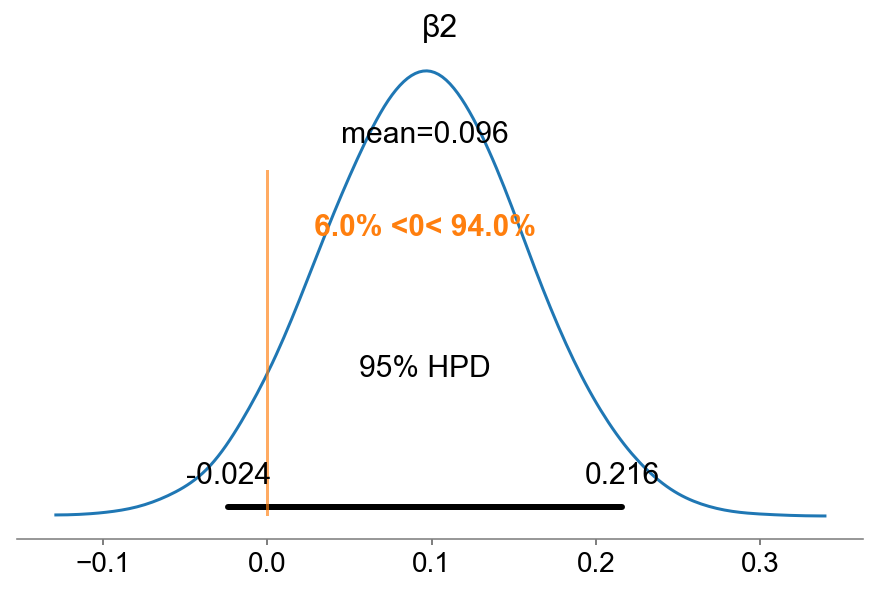

In [20]:
pm.plot_posterior(posterior_money, var_names=['β2'], ref_val=0, color='#87ceeb', round_to=3, credible_interval=0.95);

In [21]:
# posterior mean and std of β2
np.mean(posterior_money['β2']), np.std(posterior_money['β2'])

(0.09562628550672347, 0.06136190678539607)

In [22]:
# ?pm.plot_posterior

In [23]:
def posterior_prediction_plot(ax, posterior, data, logk):
    xi = np.percentile(logk, [0, 100])
    age = np.linspace(18, 80, 20)

    # min
    bmi_gain_per_decade =  posterior['β1'] + posterior['β2'] * xi[0]
    bmi_gain_per_year = bmi_gain_per_decade/10
    bmi = np.expand_dims(posterior['β0'],axis=1) + np.expand_dims(bmi_gain_per_year,axis=1) @ np.expand_dims(age, axis=0)
    lower = np.percentile(bmi, [2.5, 50, 95], axis=0)

    # max
    bmi_gain_per_decade =  posterior['β1'] + posterior['β2'] * xi[1]
    bmi_gain_per_year = bmi_gain_per_decade/10
    bmi = np.expand_dims(posterior['β0'],axis=1) + np.expand_dims(bmi_gain_per_year,axis=1) @ np.expand_dims(age, axis=0)
    upper = np.percentile(bmi, [2.5, 50, 95], axis=0)

    # PLOTTING
    ax.scatter(data['age']*10, data['bmi'], c='k', alpha=0.5, label='data');

    ax.fill_between(age, upper[0,:], upper[2,:], alpha=0.2, color='r', edgecolor='w')
    ax.plot(age, upper[1,:], color='r', linewidth=3, label='max')

    ax.fill_between(age, lower[0,:], lower[2,:], alpha=0.2, color='b', edgecolor='w')
    ax.plot(age, lower[1,:], color='b', linewidth=3, label='min')

    ax.legend()

    ax.set(xlabel='Age [years]', 
            ylabel=r'BMI [kg/m$^2$]', 
            title=r'Posterior predicted BMI, conditioned upon $\log(k)$ value');
    #ax.set_ylim(bottom=0)

    ax.text(52, 14, r'$BMI = \beta_0 + (\beta_1 + \beta_2 \cdot \log(k)) \cdot age$', fontsize=16, usetex=True)

    #ax.text(52, 3, r'$BMI = \beta_0 + \beta_1 \cdot age + \beta_2 \cdot age \cdot \log(k)$', fontsize=16, usetex=True)

    # eq1 = r"\begin{eqnarray*}" + \
    #       r"BMI &=& \beta_0 + (\beta_1 + \beta_2 \cdot \log(k)) \cdot age\\" + \
    #       r"    &=& \beta_0 + \beta_1 \cdot age + \beta_2 \cdot age \cdot \log(k)" + \
    #       r"\end{eqnarray*}"
    # ax.text(50, 3, eq1, fontsize=16, usetex=True)
    return ax

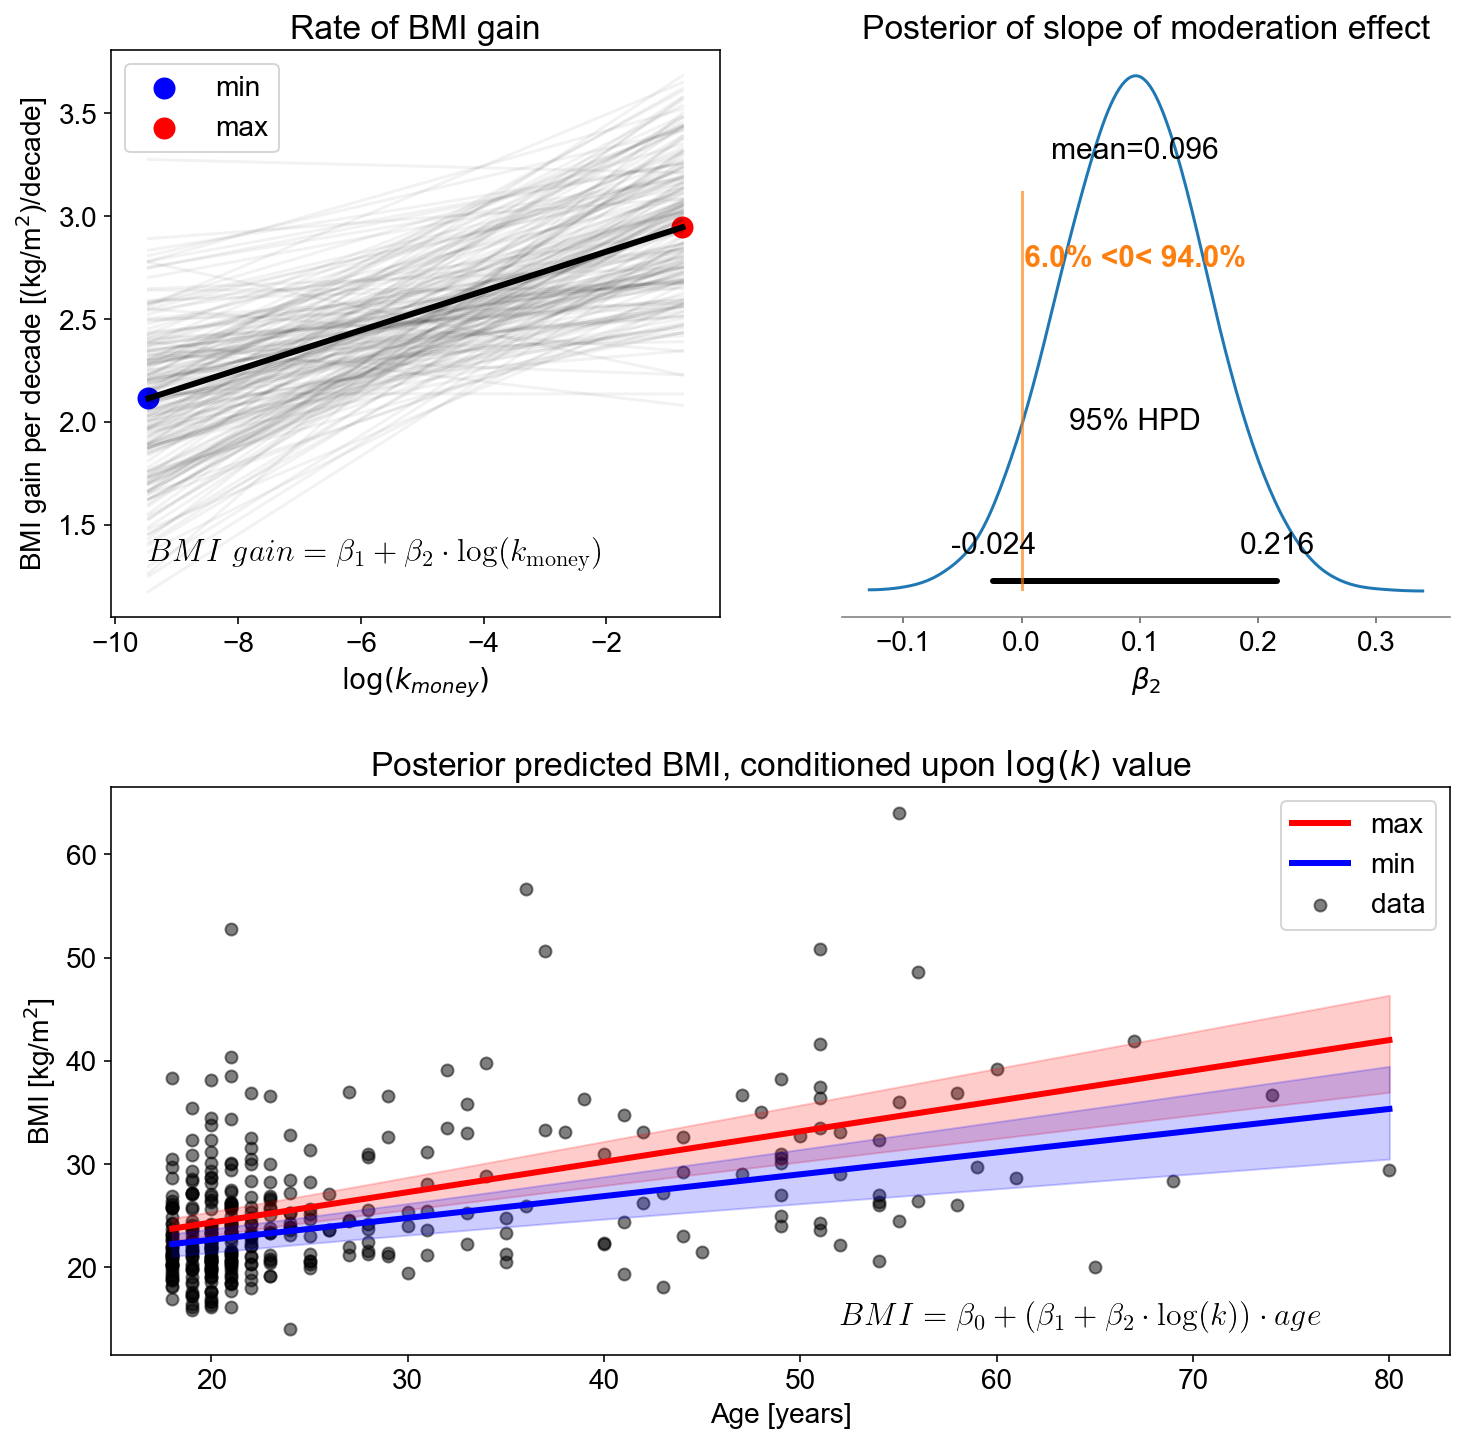

In [24]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(12, 12)) 

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

# ----------------------------------------------------
ax1 = plot_moderation(ax=ax1, x=data['logk_money'], 
                      intercept=posterior_money['β1'], 
                      slope=posterior_money['β2'], 
                      ax_kwargs={'xlabel': r'$\log(k_{money})$',
                                 'ylabel': r'BMI gain per decade [(kg/m$^2$)/decade]',
                                 'title': 'Rate of BMI gain'})

ax1.text(np.min(data['logk_money']), 1.3, r'$BMI~gain = \beta_1 + \beta_2 \cdot \log(k_\mathrm{money})$', fontsize=16, usetex=True)

# ----------------------------------------------------
# multiply β2 by 10 so we can get rate in BMI gain per decade
ax2 = pm.plot_posterior(posterior_money['β2'], ref_val=0, color='#87ceeb', ax=ax2, round_to=3, credible_interval=0.95);
ax2.set(title=r'Posterior of slope of moderation effect', 
        xlabel=r"$\beta_2$")


# ----------------------------------------------------
ax3 = posterior_prediction_plot(ax3, posterior_money, data, data['logk_money'])

# ----------------------------------------------------
plt.subplots_adjust(hspace=0.3)

plt.savefig('figs/rate_money.pdf', bbox_inches='tight')

Let's see how meaningful the effect of the moderation is alone, independent from the effects of age. We will calculate the amount og weight we would gain for a given rate of BMI gain and a duration. We assume someone of average height (from our sample) of 1.7 meters and with an initial BMI of 22.5.

In [25]:
def weight_gain(BMI_gain_per_decade, num_decades, initial_BMI=22.5, height=1.7):
    '''Calculate amount of weight gained for a given rate of BMI gain and the duration'''
    weight_t1 = initial_BMI / (height**2)
    weight_t2 = (initial_BMI + BMI_gain_per_decade * num_decades)/ (1.7**2)
    weight_gain = weight_t2 - weight_t1
    return weight_gain

If you have the lowest level of discounting then your BMI increases by about ~2 per decade. So let's see how much weight gain this corresponds to:

In [26]:
weight_gain(BMI_gain_per_decade=2, num_decades=1)

0.6920415224913503

If you have the highest level of discounting then your BMI increases by about ~3 per decade. So how much weight gain does this result in?

In [27]:
weight_gain(BMI_gain_per_decade=3, num_decades=1)

1.0380622837370241

And to judge the meaningfullness of this moderation term, we calculate the difference in weight gained if you have the highest versus lowest level of discounting.

In [28]:
weight_gain(BMI_gain_per_decade=3, num_decades=1) - weight_gain(BMI_gain_per_decade=2, num_decades=1)

0.3460207612456738

**Conclusion:** So this is an incredibly small effect. If you have the highest discount rate, you will gain only 0.35 kg more _per decade_ than someone with the lowest discount rate.

# Inference for discounting of weight loss.

In [29]:
# remove rows with missing data as we don't have logk_weight for all participants
data_weight = data[np.isfinite(data['logk_weight'])]

model = make_model(x=data_weight['age'], y=data_weight['bmi'], m=data_weight['logkweight*age'])

with model:
    posterior_weight = pm.sample(**sample_options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β2, β1, β0]
Sampling 4 chains: 100%|██████████| 52000/52000 [00:34<00:00, 1492.80draws/s]


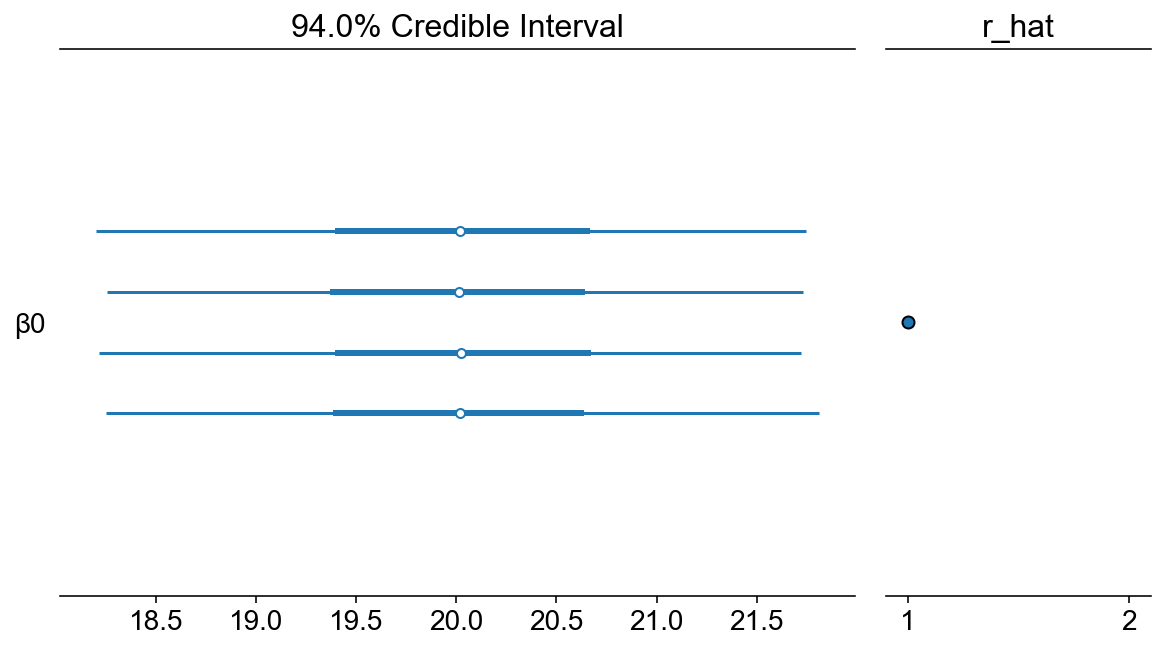

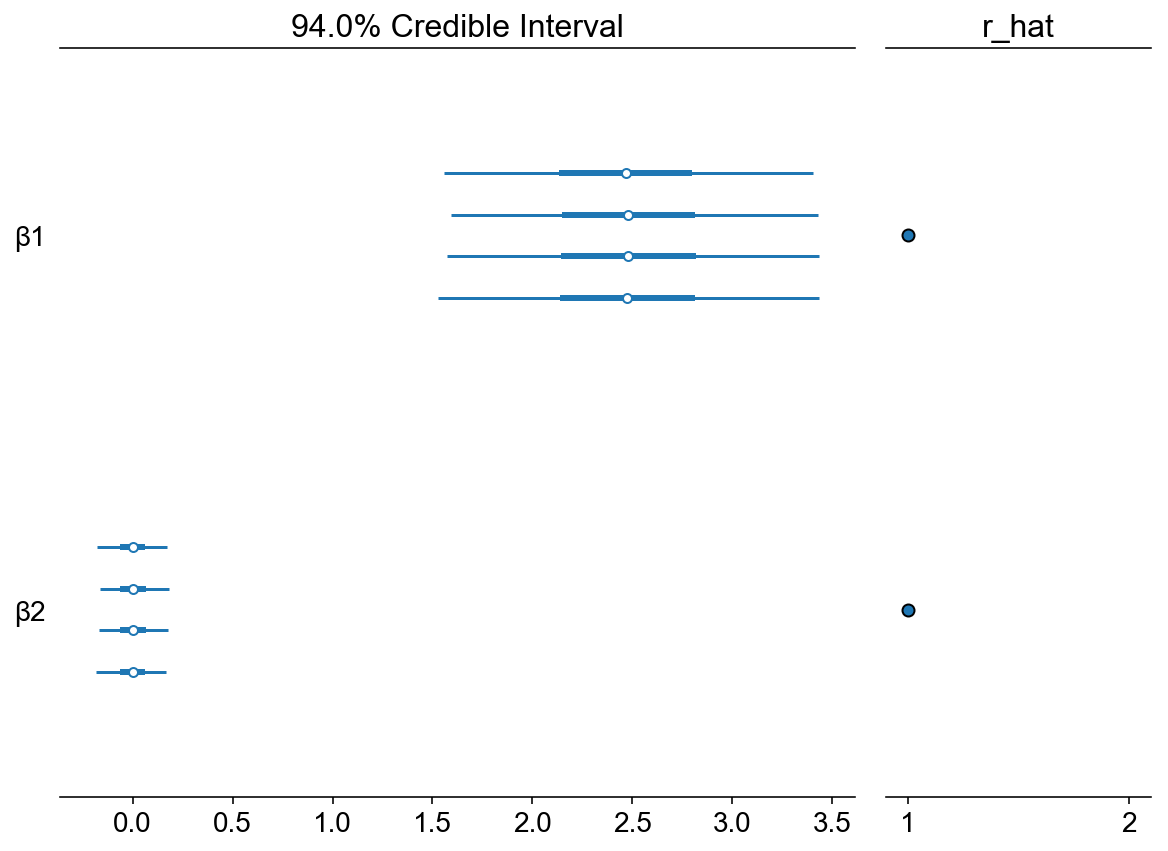

In [30]:
pm.forestplot(posterior_weight, var_names=['β0'], r_hat=True);
pm.forestplot(posterior_weight, var_names=['β1', 'β2'], r_hat=True);

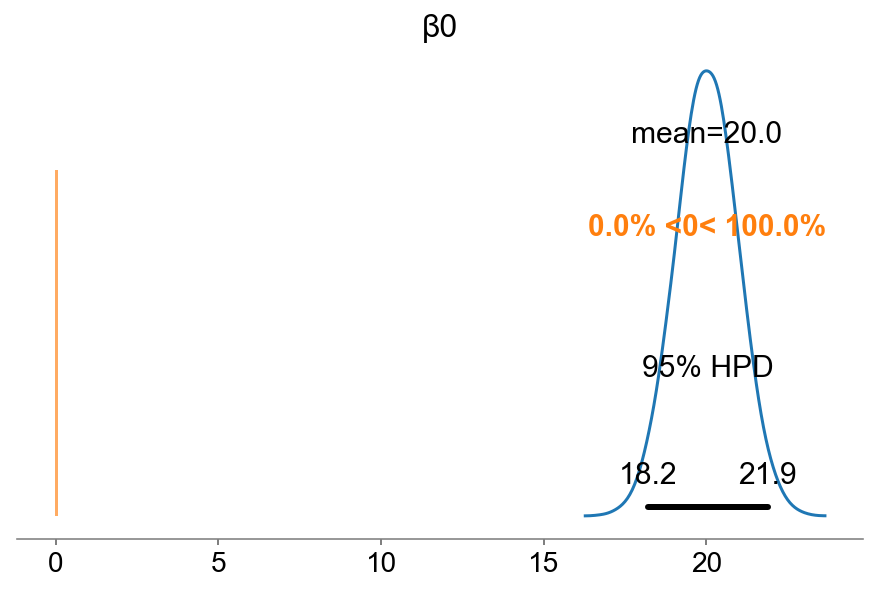

In [31]:
pm.plot_posterior(posterior_weight, var_names=['β0'], ref_val=0, color='#87ceeb', credible_interval=0.95);

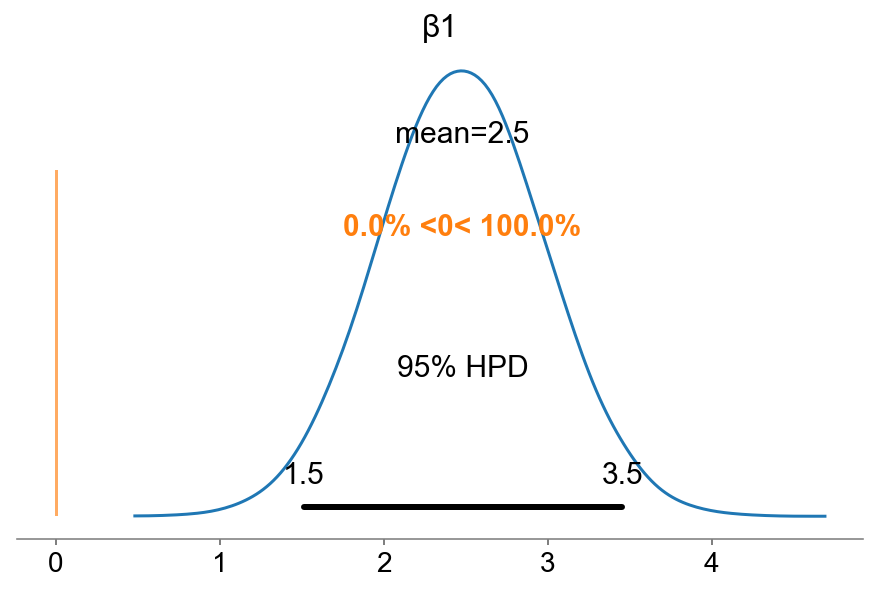

In [32]:
pm.plot_posterior(posterior_weight, var_names=['β1'], ref_val=0, color='#87ceeb', credible_interval=0.95);

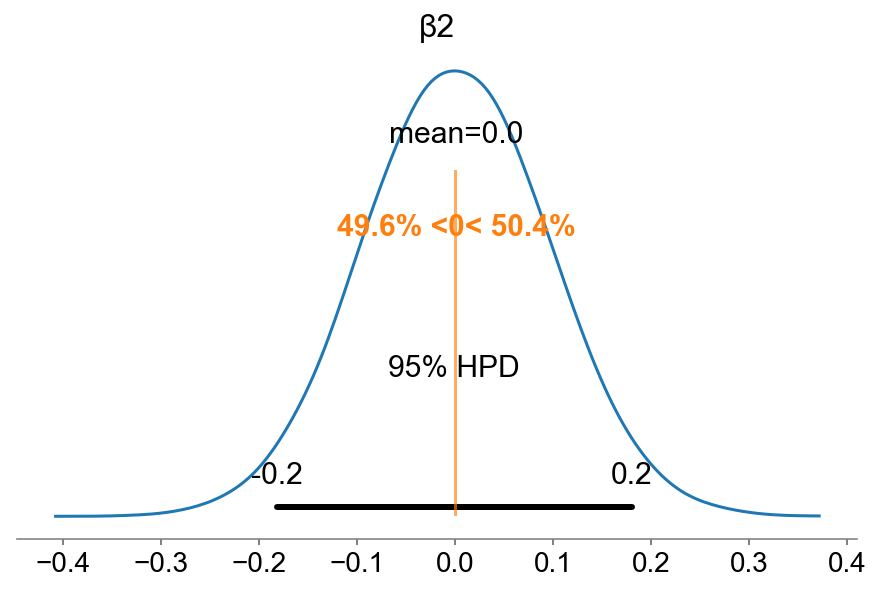

In [33]:
pm.plot_posterior(posterior_weight, var_names=['β2'], ref_val=0, color='#87ceeb', credible_interval=0.95);

In [34]:
# posterior mean and std of β2
np.mean(posterior_weight['β2']), np.std(posterior_weight['β2'])

(0.0012036925640093164, 0.09283910300946986)

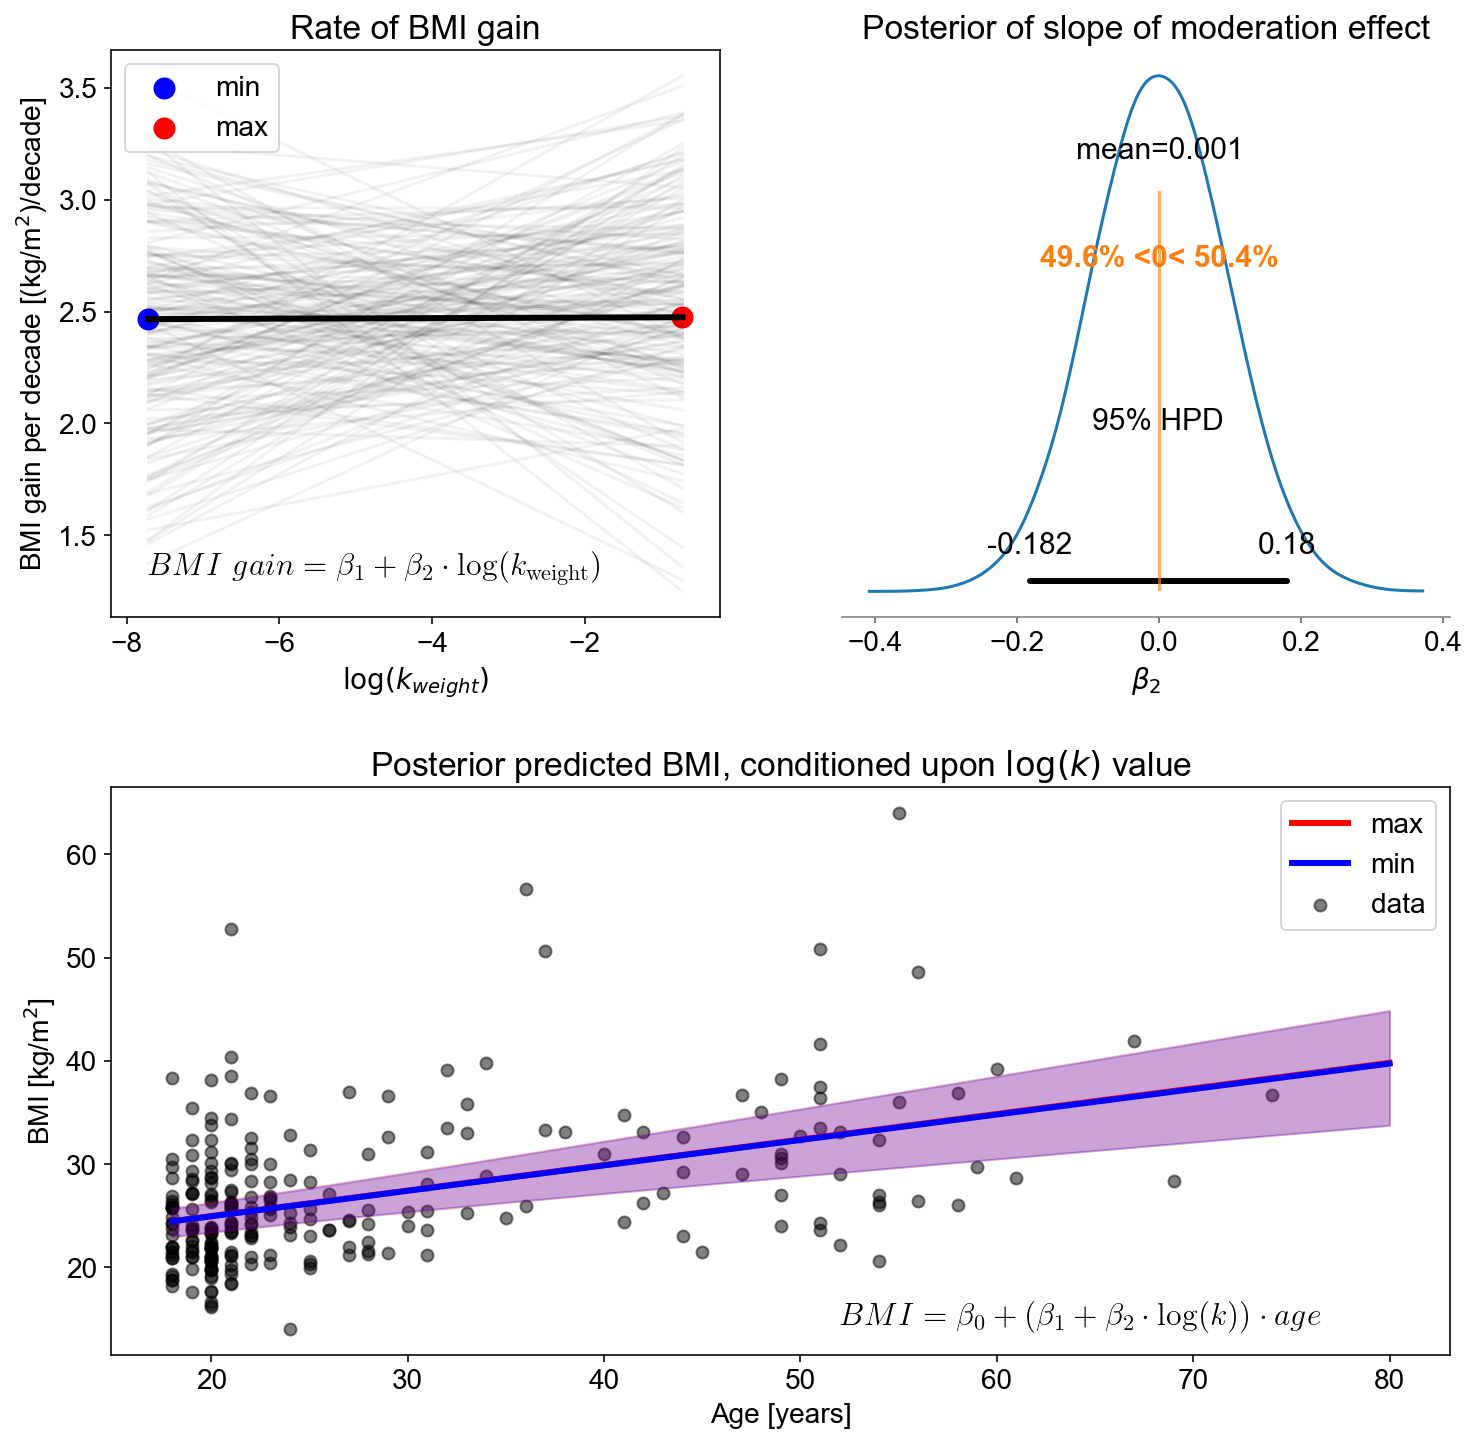

In [35]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(12, 12)) 

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

# ----------------------------------------------------
ax1 = plot_moderation(ax=ax1, x=data_weight['logk_weight'], 
                      intercept=posterior_weight['β1'], 
                      slope=posterior_weight['β2'], 
                      ax_kwargs={'xlabel': r'$\log(k_{weight})$',
                                 'ylabel': r'BMI gain per decade [(kg/m$^2$)/decade]',
                                 'title': 'Rate of BMI gain'})

ax1.text(np.min(data['logk_weight']), 1.3, r'$BMI~gain = \beta_1 + \beta_2 \cdot \log(k_\mathrm{weight})$', fontsize=16, usetex=True)

# ----------------------------------------------------
# multiply β2 by 10 so we can get rate in BMI gain per decade
ax2 = pm.plot_posterior(posterior_weight['β2'], ref_val=0, color='#87ceeb', ax=ax2, round_to=3, credible_interval=0.95);
ax2.set(title=r'Posterior of slope of moderation effect', 
        xlabel=r"$\beta_2$")


# ----------------------------------------------------
ax3 = posterior_prediction_plot(ax3, posterior_weight, data_weight, data_weight['logk_weight'])

# ----------------------------------------------------
plt.subplots_adjust(hspace=0.3)

plt.savefig('figs/rate_weight.pdf', bbox_inches='tight')

**Conclusion:** There is _no_ moderation effect here.